In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.append("../src/")

In [3]:
#export
from nb_02 import *

## Initial setup

In [4]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [5]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [6]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [7]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.695229296875, tensor(0.7971)]
valid: [0.3208802001953125, tensor(0.9093)]
train: [0.29672775390625, tensor(0.9138)]
valid: [0.25024150390625, tensor(0.9273)]
train: [0.23927466796875, tensor(0.9311)]
valid: [0.21473076171875, tensor(0.9350)]


In [8]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.7566246875, tensor(0.7985)]
valid: [0.3480057861328125, tensor(0.9027)]
train: [0.342254140625, tensor(0.9019)]
valid: [0.2847534912109375, tensor(0.9197)]
train: [0.29449251953125, tensor(0.9158)]
valid: [0.25268125, tensor(0.9278)]


In [9]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer.

In [10]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

Let's start with a simple linear schedule going from start to end. It returns a function that takes a pos argument (going from 0 to 1) such that this function goes from start (at pos=0) to end (at pos=1) in a linear fashion.

In [11]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

Refactor with a schedulator

In [12]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [13]:
f = sched_lin(1,2)
f(0.3)

1.3

In [14]:
f

functools.partial(<function sched_lin at 0x7f08e1d92268>, 1, 2)

In [15]:
sched_lin_ = annealer(sched_lin)

In [16]:
sched_lin

<function __main__.annealer.<locals>._inner(start, end)>

In [17]:
sched_lin_

<function __main__.annealer.<locals>._inner(start, end)>

In [18]:
f = sched_lin_(1,2)
f

functools.partial(<function annealer.<locals>._inner at 0x7f08e1d920d0>, 1, 2)

In [19]:
f = sched_lin(1,2)
f

functools.partial(<function sched_lin at 0x7f08e1d92268>, 1, 2)

Other scheduler functions

In [20]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

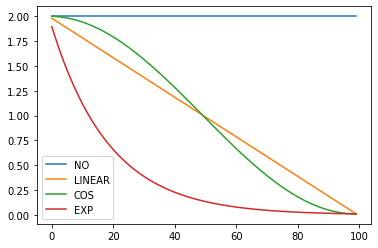

In [21]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In practice, we'll often want to combine different schedulers, the following function does that: it uses scheds[i] for pcts[i] of the training.

In [22]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [23]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [26]:
torch.cumsum(tensor([0, 0.5, 0.5]), 0)

tensor([0.0000, 0.5000, 1.0000])

In [36]:
(0.6 > tensor([0, 0.5, 1])).nonzero().max()

tensor(1)

In [41]:
(0.6-tensor([0, 0.5, 1])[1]) / (tensor([0, 0.5, 1])[1+1]-tensor([0, 0.5, 1])[1])

tensor(0.2000)

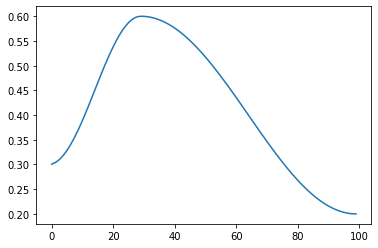

In [45]:
plt.plot(a, [sched(o) for o in p])

In [46]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [47]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [48]:
run.fit(3, learn)

train: [0.794909453125, tensor(0.7850)]
valid: [0.328009814453125, tensor(0.9053)]
train: [0.29825248046875, tensor(0.9122)]
valid: [0.2375922607421875, tensor(0.9309)]
train: [0.23599501953125, tensor(0.9326)]
valid: [0.20939169921875, tensor(0.9425)]


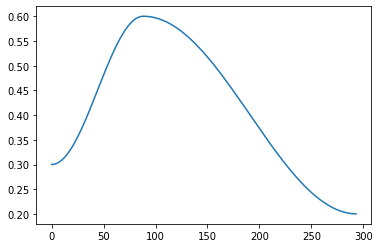

In [49]:
run.recorder.plot_lr()

In [56]:
len(data.train_ds)

50000

In [67]:
data.train_dl.batch_size 

512

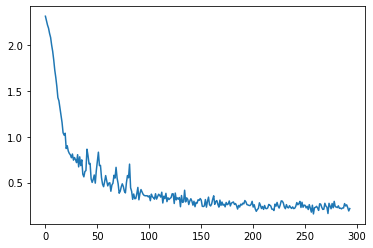

In [73]:
run.recorder.plot_loss()

## Export

In [78]:
%%bash
python3 "../src/notebook2script.py" 03_callback_anneal.ipynb

Converted 03_callback_anneal.ipynb to ../src/nb_03.py
